In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from analysis.metrics import compute_aggregate_metrics, get_run_results, diff_proposal

In [77]:
def load_jsonl(filepath):
    data = []
    with open(filepath, "r") as f:
        for line in f:
            data.append(json.loads(line))
    return data

results = load_jsonl("../experiments/results.jsonl")

for r in results:
    r["rounds"] = r["history"][-1]["round"] + 1

runs = [
    "new_profit_vs_fair_0.0_gpt-5.2_no_remaining",
    "new_fair_vs_fair_0.0_gpt-5.2",
    "new_profit_vs_tit_for_tat_0.0_gpt-5.2",
    "new_fair_vs_tit_for_tat_0.0_gpt-5.2",
    "new_fair_vs_hardliner_0.0_gpt-5.2",
    "new_hardliner_vs_fair_0.0_gpt-5.2",
    "new_hardliner_vs_profit_0.0_gpt-5.2",
    "new_hardliner_vs_hardliner_0.0_gpt-5.2"
]

runs_metrics = []

for run in runs:
    run_results = get_run_results(results, run)
    df = pd.DataFrame(run_results)
    metrics = compute_aggregate_metrics(run_results)
    metrics["run_name"] = run
    runs_metrics.append(metrics)

runs_metrics_df = pd.DataFrame(runs_metrics)
cols = ["run_name"] + [c for c in runs_metrics_df.columns if c != "run_name"]
runs_metrics_df = runs_metrics_df[cols]

runs_metrics_df


,run_name,total_runs,agreement_rate,avg_rounds,avg_utilities,fairness_index,avg_convergence
0,new_profit_vs_fair_0.0_gpt-5.2_no_remaining,1,1.0,4.0,"{'Alice': 62.0, 'Bob': 38.0}",0.76,20.571429
1,new_fair_vs_fair_0.0_gpt-5.2,1,1.0,1.0,"{'Alice': 50.0, 'Bob': 50.0}",1.00,0.000000
2,new_profit_vs_tit_for_tat_0.0_gpt-5.2,1,1.0,3.0,"{'Alice': 65.0, 'Bob': 35.0}",0.70,26.000000
3,new_fair_vs_tit_for_tat_0.0_gpt-5.2,1,1.0,1.0,"{'Alice': 50.0, 'Bob': 50.0}",1.00,0.000000
4,new_fair_vs_hardliner_0.0_gpt-5.2,1,1.0,4.0,"{'Alice': 40.0, 'Bob': 60.0}",0.80,6.857143
5,new_hardliner_vs_fair_0.0_gpt-5.2,1,1.0,5.0,"{'Alice': 62.0, 'Bob': 38.0}",0.76,13.333333
6,new_hardliner_vs_profit_0.0_gpt-5.2,1,1.0,4.0,"{'Alice': 65.0, 'Bob': 35.0}",0.70,6.571429
7,new_hardliner_vs_hardliner_0.0_gpt-5.2,1,0.0,10.0,"{'Alice': 45.0, 'Bob': 55.0}",0.90,40.526316


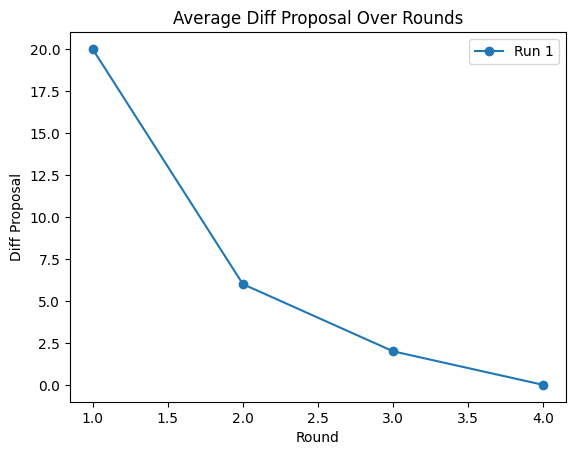

In [80]:
run_results = run_results = get_run_results(results, "new_hardliner_vs_fair_0.0_gpt-5.2")

for n_run, run in enumerate(run_results):
    agent_names = set([entry["agent_name"] for entry in run["history"]])
    rounds = sorted(set([entry["round"] for entry in run["history"]]))
    agent_diffs = {agent_name: [] for agent_name in agent_names}
    for agent_name in agent_names:
        agent_history = [entry for entry in run["history"] if entry["agent_name"] == agent_name]
        diffs = []
        for i in range(1, len(agent_history)):
            agent_proposal = agent_history[i]["proposal"]
            other_agent_proposals = [entry["proposal"] for entry in run["history"] if entry["agent_name"] != agent_name and entry["round"] == agent_history[i]["round"]]
            if other_agent_proposals:
                other_agent_proposals_mean = {
                    "shares": {
                        "Alice": sum(p["shares"]["Alice"] for p in other_agent_proposals) / len(other_agent_proposals),
                        "Bob": sum(p["shares"]["Bob"] for p in other_agent_proposals) / len(other_agent_proposals)
                    }
                }
                diff = diff_proposal(agent_proposal, other_agent_proposals_mean)
                diffs.append(diff["Alice"] + diff["Bob"])
        agent_diffs[agent_name] = diffs

    avg_diffs = [sum(agent_diffs[agent_name][i] for agent_name in agent_names) / len(agent_names) for i in range(len(rounds)-1)]
    plt.plot(range(1, len(rounds)), avg_diffs, marker='o', label=f"Run {n_run+1}")

plt.title("Average Diff Proposal Over Rounds")
plt.xlabel("Round")
plt.ylabel("Diff Proposal")
plt.legend()
plt.show()